# Techniques d'apprentissage automatique
## TP3 - Détection d’anomalies avec Python
### Alexis Pister

In [14]:
import numpy as np
np.set_printoptions(threshold=100)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## Jeu de donnée Mouse

                x           y
count  500.000000  500.000000
mean     0.505892    0.599706
std      0.191763    0.156863
min      0.040555    0.138940
25%      0.328481    0.469010
50%      0.504702    0.629494
75%      0.681430    0.735364
max      0.916030    0.897028


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f84e4e57710>,
      dtype=object)

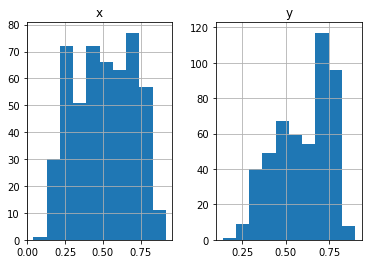

In [15]:
# Data
mousedata = pd.read_csv('./mouse.txt', sep=" ", header=None, names=['x', 'y'])
mousevalues = mousedata.values

# Description du jeu de données
print(mousedata.describe())
mousedata.hist()

Text(0,0.5,'y')

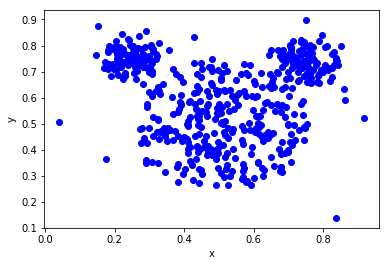

In [16]:
# Representation graphique des données
plt.plot(mousedata['x'], mousedata['y'], 'bo')
plt.xlabel('x')
plt.ylabel('y')

In [17]:
# On applique la technique d'isolation forest pour detecter les anomalies
from sklearn.ensemble import IsolationForest

IF = IsolationForest(random_state=1)
IFout = IF.fit_predict(mousevalues)

# Indices des inliners et outliers
inliners = np.where(IFout == 1)
outliers = np.where(IFout == -1)

# Arrays des inliners et outliers
dataoutliers = mousevalues[outliers[0],]
datainliners = mousevalues[inliners[0],]

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:418: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Text(0,0.5,'y')

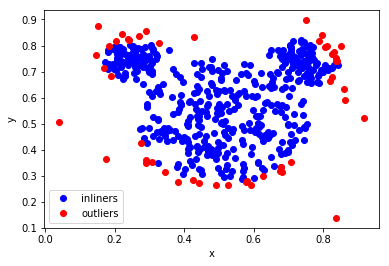

In [18]:
# Plot des outliers sur les données
plt.plot(datainliners[:,0], datainliners[:,1], 'bo')
plt.plot(dataoutliers[:,0], dataoutliers[:,1], 'ro')
plt.legend(['inliners', 'outliers'])
plt.xlabel('x')
plt.ylabel('y')

On constate que la technique d'Isolation Forest marche assez bien : tous les points éloignés de la silhouette de la souris sont détéctés. Cependant, des groupes de points qui auraient pu être considérés comme faisant parti du dessin sont aussi considérés comme des anomalies, notamment sur le bas de la tête de la souris.

## Jeu de donnée des cartes de crédit

In [72]:
# Data
transdata = pd.read_csv('./creditcard.csv', sep=",", )

# Lignes de fraude et 5000 lignes normales
frauddata = transdata[transdata['Class'] == 1]
normaldata = transdata[transdata['Class'] == 0].sample(5000)

# On enleve la colonne time
fraudvalues = frauddata.values[:,1:]
normalvalues = normaldata.values[:,1:]

# Fusion
transvalues = np.vstack((normalvalues, fraudvalues))

# Dimension du jeu de données traité
print(transvalues.shape)

# Separation des variables explicatives et labels
X = transvalues[:,:-1]
Y = transvalues[:,-1]

(5492, 30)


In [73]:
from sklearn.metrics import confusion_matrix, classification_report

# Isolation Forest
Ypred = IF.fit_predict(X)
Ypred[Ypred == 1] = 0
Ypred[Ypred == -1] = 1

# Resultats
print(confusion_matrix(Ypred, Y))
print(classification_report(Ypred, Y))

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/iforest.py:418: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


[[4803  139]
 [ 197  353]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      4942
           1       0.72      0.64      0.68       550

   micro avg       0.94      0.94      0.94      5492
   macro avg       0.84      0.81      0.82      5492
weighted avg       0.94      0.94      0.94      5492



Les résulats peuvent sembler bons étant donné que l'accuracy pondérée est de 0.94. Cependant, sur ce jeu de données c'est majoritairement le rappel sur les fraudes qui nous intéresse : ne pas détécter une fraude est bien plus couteux que d'envoyer un sms d'alerte sur une transaction non frauduleuse. Le rappel sur la classe 1 est de 0.64, ce qui veut dire que 36% des fraudes ne sont pas détéctés ce qui est relativement élevé. Sur un tel jeu de données l'objectif est d'augmenter ce nombre, quitte à faire diminuer la précision de la détéction des fraude. Il faut néanmoins trouver un équilibre entre les 2 valeurs et ne pas faire trop diminuer la précision non plus.

In [94]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# On réalise une ACP pour la visualisation des données sur 2 axes : on garde seulement les 2 premieres composantes

acp = PCA(n_components=2)
XPCA = acp.fit_transform(StandardScaler().fit_transform(X))
XPCA_fraud = XPCA[5000:]
XPCA_norm = XPCA[:5000]

Text(0,0.5,'Comp2')

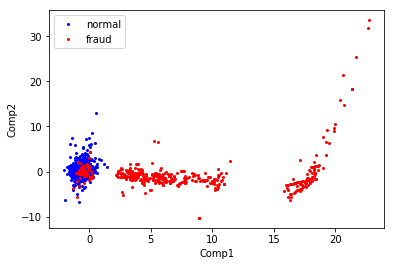

In [95]:
# Plot des frauds à partir des labels des données
plt.plot(XPCA_norm[:,0], XPCA_norm[:,1], 'bo', markersize=2.0)
plt.plot(XPCA_fraud[:,0], XPCA_fraud[:,1], 'ro', markersize=2.0)
plt.legend(['normal', 'fraud'])
plt.xlabel('Comp1')
plt.ylabel('Comp2')

550
4942


Text(0,0.5,'Comp2')

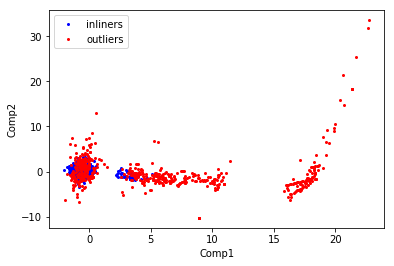

In [96]:
# Indices des inliners et outliers
inliners = np.where(Ypred == 0)
outliers = np.where(Ypred == 1)
print(len(outliers[0]))
print(len(inliners[0]))

# Plot des outliers detectés pas l'isolation forest
plt.plot(XPCA[inliners[0],0], XPCA[inliners[0],1], 'bo', markersize=2.0)
plt.plot(XPCA[outliers[0],0], XPCA[outliers[0],1], 'ro', markersize=2.0)
plt.legend(['inliners', 'outliers'])
plt.xlabel('Comp1')
plt.ylabel('Comp2')

Grâce à l'ACP, on peut essayer de caractériser visuellement les fraudes du jeu de données. On remarque sur le premier graphique que les transactions frauduleuses sont principalement caractérisées par des valeurs éloignées de 0 sur les 2 axes de l'ACP, alors que les transactions normales sont relativement centrées autour de l'origine (0,0).  
Si on plot maintenant les anomalies détéctées par l'Isolation Forest, on voit que l'algorithme detecte la plupart des fraudes ayant une forte valeur sur l'axe 1, mais considère beaucoup de valeurs centrées à 0 sur l'axe 1 comme une fraude alors que ce sont des transactions normales. Ces visualisations mettent en évidence la complexité de la tâche : beaucoup de transactions frauduleuses ont des valeurs très similaires aux transactions normales, ce qui les rend très difficiles à détecter, voir impossibles.